# **Logistic Regression on IMDB Dataset**

# Import the libraries

In [8]:
# Import the librairies
from sklearn.datasets import load_svmlight_file
import matplotlib.pylab as plt
import scipy
import math
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

# Logistic regression model

In [9]:
# Define the class to perform the logistic regression
class Logistic_regression:
    def __init__(self, number_feature, bias = True, learning_rate = 2e-4, eps = 1e-4, max_iteration = 10000):
        self.number_feature = number_feature
        self.learning_rate = learning_rate
        self.eps = eps
        self.max_iteration = max_iteration
        self.list_cross_entropy_train = []
        self.list_cross_entropy_val = []
        self.list_gradient = []
        self.number_iteration_reached = 0
        self.bias = bias

    def gradient(self, X, y, weights_vector):
        return np.matmul(X.transpose(), np.reciprocal(1 + np.exp(-np.dot(X, weights_vector))) - y)

    def cross_entropy(self, X, y, weights_vector):
        return  np.sum(-y * np.log(np.reciprocal(1 + np.exp(-np.dot(X, weights_vector)))) - (1-y) * np.log(1-np.reciprocal(1 + np.exp(-np.dot(X, weights_vector)))))

    def fit(self, X, X_val, y, y_val):
        if self.bias:
            X = np.column_stack([X, np.ones(len(X))])
            X_val = np.column_stack([X_val, np.ones(len(X_val))])
        weights_vector = np.zeros((len(X[0]),1))
        grad = self.gradient(X, y, weights_vector)
        self.list_cross_entropy = []
        self.list_gradient = []
        self.number_iteration_reached = 0
        delta_cross_entropy_val = -np.inf
        cross_entropy_val = np.inf
        while np.linalg.norm(grad) > self.eps and self.number_iteration_reached < self.max_iteration and delta_cross_entropy_val < 0:
            grad = self.gradient(X, y, weights_vector)
            self.list_gradient.append(np.linalg.norm(grad))
            weights_vector = weights_vector - self.learning_rate * grad
            previous_cross_entropy_val = cross_entropy_val
            cross_entropy_val = self.cross_entropy(X_val, y_val, weights_vector)
            delta_cross_entropy_val = cross_entropy_val - previous_cross_entropy_val
            self.list_cross_entropy_val.append(cross_entropy_val)
            self.list_cross_entropy_train.append(self.cross_entropy(X, y, weights_vector))
            self.number_iteration_reached = self.number_iteration_reached + 1
        return [self.number_iteration_reached, np.linalg.norm(grad), weights_vector]
    
    def predict(self, X, weights_vector):
        if self.bias:
            X = np.column_stack([X, np.ones(len(X))])
        y_pred = np.reciprocal(1 + np.exp(-np.dot(X, weights_vector)))
        return y_pred

# Linear regression model

In [10]:
# Define the class to perform the linear regression
class Linear_regression:
    def __init__(self, bias = True):
        self.bias = bias
    
    def fit(self, x, y):                       
        number_sample = x.shape[0]
        if self.bias:
            x = np.column_stack([x,np.ones(number_sample)])   
        weights = np.linalg.lstsq(x, y)[0]
        return weights
    
    def predict(self, x, weights):
        number_sample = x.shape[0]
        if self.bias:
            x = np.column_stack([x, np.ones(number_sample)])
        y_pred = np.dot(x, weights)
        return y_pred

# Useful metrics

In [11]:
# Plot the most important evaluation metrics for classification
def metrics(y_test, y_pred):
    TP = np.sum(np.logical_and(y_test == 1, y_pred==1))
    TN = np.sum(np.logical_and(y_test == 0, y_pred==0))
    FP = np.sum(np.logical_and(y_test == 0, y_pred==1))
    FN = np.sum(np.logical_and(y_test == 1, y_pred==0))
    if TP ==0 :
        Recall=0
        F1=0
        Precision=0
    else:
        Recall = TP /(TP + FN)
        Precision = TP /(TP + FP)
        F1 = 2*(Recall*Precision)/(Recall+Precision)
    print('Accuracy:',str(round((np.sum(y_test == y_pred)/len(y_pred))*100,2))+'%')
    print('Confusion Matrix :', [[TP,FP],[FN, TN]] )
    print('Recall :', round(Recall,2))
    print('Precision :', round(Precision,2))
    print('F1 Score :', round(F1,2))

In [12]:
# Create the RO curve
def RO_curve(y_test, y_prob):
    FPR_list=[]
    TPR_list=[]
    threshold_list=np.linspace(-0.1,1.1,100)
    for threshold in threshold_list:
        y_pred = y_prob > threshold
        if threshold == 1:
            Precision = 1
            Recall =0
        else:
            TP = np.sum(np.logical_and([y_test == 1], [y_pred==1]))
            TN = np.sum(np.logical_and([y_test == 0], [y_pred==0]))
            FP = np.sum(np.logical_and([y_test == 0], [y_pred==1]))
            FN = np.sum(np.logical_and([y_test == 1], [y_pred==0]))
            FPR = FP /(FP + TN)
            TPR = TP /(TP + FN)
        FPR_list.append(FPR)
        TPR_list.append(TPR)
    return FPR_list,TPR_list

In [13]:
# Compute the AUC associated to RO curve
def RO_AUC(y_test, y_pred):
    FPR_list, TPR_list = RO_curve(y_test, y_pred)
    list_index=np.argsort(FPR_list)
    X=np.sort(FPR_list)
    Y=[TPR_list[i] for i in list_index]
    area=0
    for i in range(len(X)-1):
        area = area+(X[i+1]-X[i])*(Y[i]+Y[i+1])/2
    return area

# Data importation and preparation

In [14]:
# Import the vocabulary file
vocab = open("imdb.vocab", encoding="utf8").read().split()

In [15]:
# Import the train dataset
file_labeledBOW_train = load_svmlight_file('labeledBow_train.feat')
df_text_train = pd.DataFrame.sparse.from_spmatrix(file_labeledBOW_train[0], columns = vocab)
df_text_train

,the,and,a,of,to,is,it,in,i,this,...,italian-born,peanut-butter,drug-centred,profanity-laced,sarah-michelle,copywrite,artbox,kinky-sex,urrrghhh,investigator-like
0,9.0,1.0,4.0,4.0,6.0,4.0,2.0,2.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.0,4.0,2.0,2.0,0.0,4.0,1.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,4.0,4.0,7.0,2.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10.0,2.0,2.0,0.0,3.0,2.0,4.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.0,9.0,6.0,4.0,2.0,5.0,10.0,6.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,36.0,16.0,18.0,15.0,11.0,8.0,4.0,11.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,4.0,8.0,8.0,3.0,3.0,0.0,6.0,3.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,17.0,6.0,7.0,5.0,1.0,2.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,15.0,8.0,3.0,6.0,0.0,6.0,2.0,3.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Display the score associated to the train dataset
df_score_train = pd.DataFrame(file_labeledBOW_train[1], columns = ['Score'])
df_score_train 

,Score
0,9.0
1,7.0
2,9.0
3,10.0
4,8.0
...,...
24995,1.0
24996,1.0
24997,4.0
24998,2.0


In [17]:
# Create a boolean version of the same dataframe giving a 1 if the world appears at least one time in each sample and 0 otherwise
df_text_int = df_text_train.copy()
for features in df_text_int.columns:
    df_text_int[features] = df_text_int[features] >= 1
df_text_int = df_text_int.astype(int)
df_text_int

,the,and,a,of,to,is,it,in,i,this,...,italian-born,peanut-butter,drug-centred,profanity-laced,sarah-michelle,copywrite,artbox,kinky-sex,urrrghhh,investigator-like
0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
24996,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
24997,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
24998,1,1,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Get the sorted percentage of occurence for each word
df_text_perc = df_text_int.sum()/len(df_text_int)*100
df_text_perc = df_text_perc.to_frame()
df_text_perc.columns = ['%']
df_text_perc = df_text_perc.sort_values(by=['%'], ascending=False)
df_text_perc

,%
the,99.168
a,96.692
and,96.648
of,94.888
to,93.836
...,...
hrabal,0.004
standing-up,0.004
you-know-who,0.004
destabilize,0.004


In [19]:
# Drop the words that appear in less than 1% of the documents (too rare) and more than 50% of the documents (too common)
df_text_train = df_text_train.drop(df_text_perc.loc[np.logical_or(df_text_perc >= 50, df_text_perc < 1).to_numpy()].index, axis=1)
df_text_train

,he,his,!,by,an,who,they,from,so,like,...,prove,portray,length,discovered,aware,continues,below,opens,essentially,received
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,5.0,0.0,9.0,3.0,1.0,7.0,3.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
24996,2.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.0,2.0,0.0,2.0,1.0,2.0,3.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24998,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Create a x and y to be used with the linear regression model
x_lr = df_text_train
y_lr = df_score_train

In [21]:
# Standardize x_lr and y_lr
x_lr_dense = x_lr.sparse.to_dense().copy()
for feature in x_lr.columns:
    mean = x_lr_dense[feature].mean()
    sd = x_lr_dense[feature].std()
    x_lr[feature] = (x_lr[feature] - mean) / sd
for feature in y_lr.columns:
    mean = y_lr[feature].mean()
    sd = y_lr[feature].std()
    y_lr[feature] = (y_lr[feature] - mean) / sd

In [22]:
# Fit a linear regression using x_lr and y_lr with a bias
lr = Linear_regression(bias = True)
weights = lr.fit(x_lr, y_lr)
pd.DataFrame(weights[1:], index= x_lr.columns, columns=['weight']).sort_values(by=['weight'], ascending=False)

,weight
love,0.069052
because,0.067532
special,0.056026
several,0.041237
awful,0.040580
...,...
moments,-0.049339
what,-0.052986
style,-0.074273
will,-0.074349


In [23]:
# Compute the z-score associated to each weight
number_sample = x_lr.shape[0]
z_score = pd.DataFrame(np.matmul(x_lr.transpose().to_numpy(),y_lr.to_numpy())/np.sqrt(number_sample),index=x_lr.columns, columns=['z_score'])
z_score = z_score.sort_values(by=['z_score'])
z_score

,z_score
bad,-42.993320
worst,-41.417694
waste,-33.465220
awful,-30.742401
?,-27.426691
...,...
love,20.544265
best,24.738256
excellent,25.267955
wonderful,25.660410


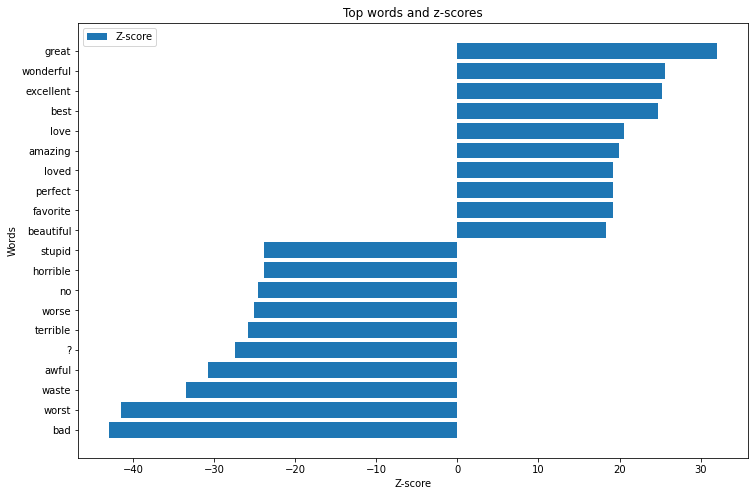

In [24]:
# Draw the bar plot of top features from Linear Regression
scores = z_score.values.tolist()
scores = sum(scores, [])
num_feature=10
word_list = []
score_list = []
for i, j in zip(z_score.index[:num_feature],scores[:num_feature]):
    word_list.append(i)
    score_list.append(j)
for i, j in zip(z_score.index[-num_feature:],scores[-num_feature:]) :
    word_list.append(i)
    score_list.append(j)
fig = plt.subplots(figsize =(12, 8))
plt.barh(word_list, score_list, label='Z-score')
plt.xlabel('Z-score')
plt.ylabel('Words')
plt.title('Top words and z-scores')
plt.legend(loc=2)
plt.show()

In [25]:
# Compute the p-values associated to each weight
p_value = pd.DataFrame(scipy.stats.norm.sf(abs(z_score.to_numpy()))*2, index = z_score.index, columns=['p_value'])
p_value = p_value.sort_values(by=['p_value'])
p_value

,p_value
bad,0.000000e+00
worst,0.000000e+00
waste,1.546038e-245
great,1.515446e-225
awful,1.544994e-207
...,...
negative,9.847699e-01
fighting,9.877415e-01
common,9.931549e-01
values,9.962842e-01


In [26]:
# Trim the features with a p-value over a specific threshold
df_text_train = df_text_train.drop(p_value.loc[(p_value > 1.11e-33).to_numpy()].index, axis=1)
df_text_train

,his,there,or,just,if,?,very,even,no,only,...,garbage,touching,beautifully,laughable,excuse,outstanding,bother,redeeming,wonderfully,sucks
0,-0.529550,-0.645166,-0.615641,-0.636565,-0.672466,-0.414959,-0.561422,-0.577866,-0.540871,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
1,-0.529550,1.068695,-0.615641,-0.636565,0.328227,-0.414959,1.436236,-0.577866,-0.540871,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
2,-0.529550,-0.645166,0.240748,-0.636565,0.328227,-0.414959,-0.561422,-0.577866,-0.540871,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
3,-0.529550,-0.645166,1.097138,-0.636565,-0.672466,0.874936,-0.561422,0.565427,0.544170,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
4,-0.529550,-0.645166,-0.615641,0.259955,-0.672466,-0.414959,-0.561422,1.708720,-0.540871,0.645804,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.529550,1.068695,1.953528,1.156474,5.331691,2.809779,0.437407,-0.577866,-0.540871,1.877691,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,8.085698
24996,0.372272,-0.645166,-0.615641,-0.636565,0.328227,-0.414959,1.436236,0.565427,-0.540871,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
24997,0.372272,0.211765,1.097138,0.259955,-0.672466,-0.414959,0.437407,-0.577866,0.544170,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,7.687401,-0.11102,-0.110328,-0.091255
24998,-0.078639,-0.645166,-0.615641,-0.636565,0.328227,-0.414959,-0.561422,0.565427,-0.540871,-0.586083,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255


In [27]:
# Drop symbols '?'
df_text_train = df_text_train.drop(columns=['?'])
df_text_train

,his,there,or,just,if,very,even,no,only,well,...,garbage,touching,beautifully,laughable,excuse,outstanding,bother,redeeming,wonderfully,sucks
0,-0.529550,-0.645166,-0.615641,-0.636565,-0.672466,-0.561422,-0.577866,-0.540871,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
1,-0.529550,1.068695,-0.615641,-0.636565,0.328227,1.436236,-0.577866,-0.540871,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
2,-0.529550,-0.645166,0.240748,-0.636565,0.328227,-0.561422,-0.577866,-0.540871,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
3,-0.529550,-0.645166,1.097138,-0.636565,-0.672466,-0.561422,0.565427,0.544170,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
4,-0.529550,-0.645166,-0.615641,0.259955,-0.672466,-0.561422,1.708720,-0.540871,0.645804,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.529550,1.068695,1.953528,1.156474,5.331691,0.437407,-0.577866,-0.540871,1.877691,0.824269,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,8.085698
24996,0.372272,-0.645166,-0.615641,-0.636565,0.328227,1.436236,0.565427,-0.540871,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255
24997,0.372272,0.211765,1.097138,0.259955,-0.672466,0.437407,-0.577866,0.544170,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,7.687401,-0.11102,-0.110328,-0.091255
24998,-0.078639,-0.645166,-0.615641,-0.636565,0.328227,-0.561422,0.565427,-0.540871,-0.586083,-0.525841,...,-0.121959,-0.126277,-0.125524,-0.123063,-0.125318,-0.122858,-0.123728,-0.11102,-0.110328,-0.091255


In [28]:
file_labeledBOW_train = load_svmlight_file('labeledBow_train.feat')
df_score_train = pd.DataFrame(file_labeledBOW_train[1], columns = ['Score'])
df_score_train 

,Score
0,9.0
1,7.0
2,9.0
3,10.0
4,8.0
...,...
24995,1.0
24996,1.0
24997,4.0
24998,2.0


In [29]:
# Prepare the train datasets
x_train = df_text_train
y_train = (df_score_train >= 7).astype(int)
y_train

,Score
0,1
1,1
2,1
3,1
4,1
...,...
24995,0
24996,0
24997,0
24998,0


In [30]:
# Normalize x_train to avoid the exponential to become too big when training
for feature in x_train.columns:
    mini = x_train.loc[:,feature].min()
    maxi = x_train.loc[:,feature].max()
    x_train.loc[:,feature] = (x_train.loc[:,feature] - mini) / (maxi - mini)
x_train

,his,there,or,just,if,very,even,no,only,well,...,garbage,touching,beautifully,laughable,excuse,outstanding,bother,redeeming,wonderfully,sucks
0,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.00000,0.153846,0.0000,0.000000,0.090909,0.142857,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.00000,0.000000,0.0625,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.00000,0.000000,0.1250,0.000000,0.000000,0.000000,0.111111,0.090909,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.00000,0.000000,0.0000,0.066667,0.000000,0.000000,0.222222,0.000000,0.111111,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.00000,0.153846,0.1875,0.133333,0.545455,0.071429,0.000000,0.000000,0.222222,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857
24996,0.06250,0.000000,0.0000,0.000000,0.090909,0.142857,0.111111,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
24997,0.06250,0.076923,0.1250,0.066667,0.000000,0.071429,0.000000,0.090909,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000000
24998,0.03125,0.000000,0.0000,0.000000,0.090909,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


# Small perturbation

In [31]:
# Small perturbation to validate the correctness of the gradient calculation in the model
D = x_train.shape[1]
N = x_train.shape[0]
diff = np.zeros((D, 1))
logr = Logistic_regression(D)
weights_vector = np.random.rand(D, 1)
for i in range(D):
    epsilon = np.zeros((D, 1))
    epsilon[i] = np.random.rand() * 1e-4
    weights_vector_plus  = weights_vector  + epsilon
    J_plus = logr.cross_entropy(x_train.to_numpy(), y_train.to_numpy(), weights_vector_plus)
    weights_vector_minus  = weights_vector  - epsilon
    J_minus = logr.cross_entropy(x_train.to_numpy(), y_train.to_numpy(), weights_vector_minus)
    numeric_grad = (J_plus - J_minus) / (2 * epsilon[i])
    derived_grad = logr.gradient(x_train.to_numpy(), y_train.to_numpy(), weights_vector)[i]
    if derived_grad ==0 and numeric_grad ==0:
        diff[i] = 0
    else:
        diff[i] = np.square(derived_grad - numeric_grad).sum() / np.square(derived_grad + numeric_grad).sum()
print(diff.sum())

3.652132569203119e-16


# Train the model

In [32]:
# Create a validation part to be used as a stopping criteria during the training
x_val = x_train.sample(frac=0.3, replace=False, random_state=42)
x_train_bis = x_train.drop(index = x_val.index)
y_val = y_train.iloc[x_val.index,:]
y_train_bis = y_train.drop(index = y_val.index)
y_val

,Score
6868,1
24016,0
9668,1
13640,0
14018,0
...,...
21156,0
24654,0
14592,0
20160,0


In [33]:
# Train the model and display the resulting weight vector
logr = Logistic_regression(x_train.shape[1], bias = True, learning_rate = 2e-4, max_iteration = 1e4)
weights_vector = logr.fit(x_train_bis.to_numpy(), x_val.to_numpy(), y_train_bis.to_numpy(), y_val.to_numpy())[2]
df_weight_vector = pd.DataFrame(weights_vector[1:], index = x_train.columns).sort_values(by=[0], ascending=False)
df_weight_vector

,0
love,8.158532
today,7.158397
also,6.878183
oh,6.817498
terrible,5.875879
...,...
predictable,-7.242227
lame,-7.548005
stupid,-8.144001
worse,-8.842935


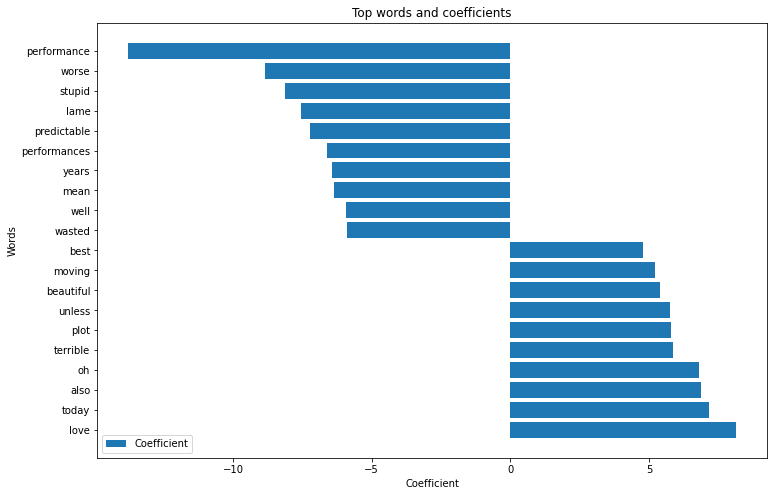

In [34]:
# Draw the bar plot of top features from Logestic Regression
coefficients = df_weight_vector.values.tolist()
coefficients = sum(coefficients, [])
num_feature = 10
word_list = []
coefficient_list = []
for i, j in zip(df_weight_vector.index[:num_feature],coefficients[:num_feature]):
    word_list.append(i)
    coefficient_list.append(j)
for i, j in zip(df_weight_vector.index[-num_feature:],coefficients[-num_feature:]) :
    word_list.append(i)
    coefficient_list.append(j)
fig = plt.subplots(figsize =(12, 8))
plt.barh(word_list, coefficient_list, label='Coefficient')
plt.xlabel('Coefficient')
plt.ylabel('Words')
plt.title('Top words and coefficients')
plt.legend(loc=3)
plt.show()

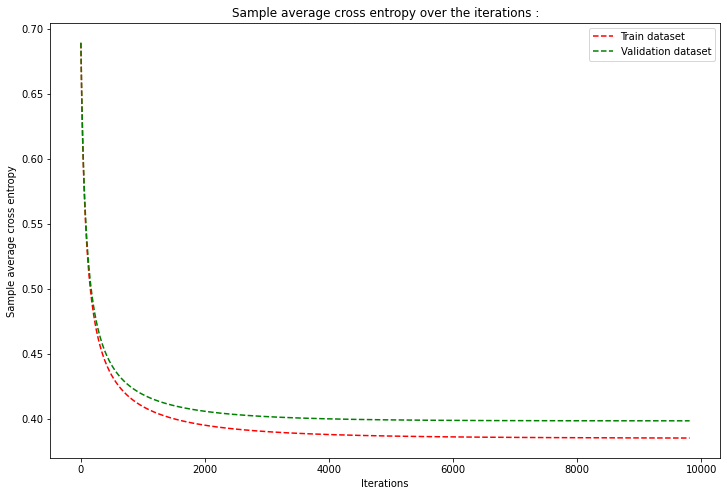

In [35]:
# Plot the training loss over the iterations
fig = plt.subplots(figsize =(12, 8))
plt.plot(list(range(0, logr.number_iteration_reached)), np.array(logr.list_cross_entropy_train) / x_train_bis.shape[0],'r--', label='Train dataset')
plt.plot(list(range(0, logr.number_iteration_reached)), np.array(logr.list_cross_entropy_val) / x_val.shape[0],'g--', label='Validation dataset')
plt.xlabel('Iterations')
plt.ylabel('Sample average cross entropy')
plt.title('Sample average cross entropy over the iterations :')
plt.legend(loc=1)
plt.show()

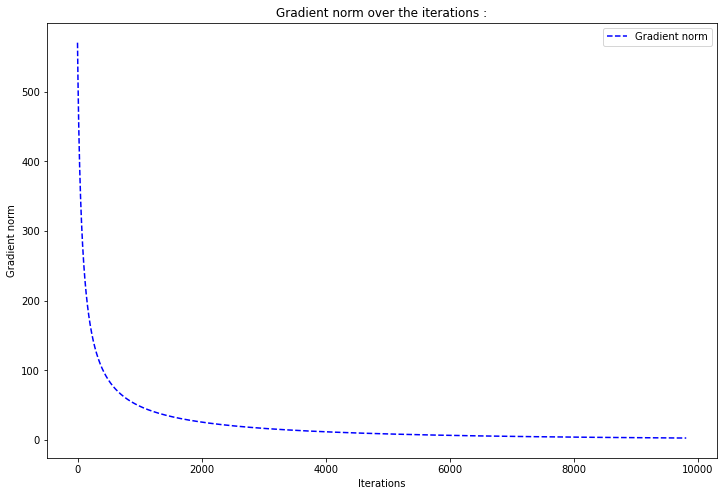

In [36]:
# Plot the gradient norm over the iterations
fig = plt.subplots(figsize =(12, 8))
plt.plot(list(range(0, logr.number_iteration_reached)), logr.list_gradient,'b--', label='Gradient norm')
plt.xlabel('Iterations')
plt.ylabel('Gradient norm')
plt.title('Gradient norm over the iterations :')
plt.legend(loc=1)
plt.show()

In [37]:
# Print the final norm of the gradient
logr.list_gradient[-1]

2.754778609172965

In [38]:
# Make prediction on the train dataset
y_prob = logr.predict(x_train_bis.to_numpy(), weights_vector)
y_pred = y_prob > 0.5

In [39]:
# Print the important classification metrics for train set
metrics(y_train_bis.to_numpy(), y_pred)

Accuracy: 82.87%
Confusion Matrix : [[7463, 1712], [1285, 7040]]
Recall : 0.85
Precision : 0.81
F1 Score : 0.83


# Test the model

In [40]:
# Import the test dataset
file_labeledBOW_test = load_svmlight_file('labeledBow_test.feat', n_features = len(vocab))
df_text_test = pd.DataFrame.sparse.from_spmatrix(file_labeledBOW_test[0], columns = vocab)
df_text_test

,the,and,a,of,to,is,it,in,i,this,...,italian-born,peanut-butter,drug-centred,profanity-laced,sarah-michelle,copywrite,artbox,kinky-sex,urrrghhh,investigator-like
0,7.0,4.0,2.0,5.0,5.0,1.0,3.0,1.0,6.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.0,4.0,4.0,0.0,3.0,1.0,10.0,1.0,12.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.0,7.0,4.0,5.0,7.0,8.0,0.0,5.0,8.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.0,5.0,8.0,8.0,4.0,2.0,6.0,4.0,8.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,26.0,0.0,10.0,10.0,10.0,11.0,12.0,9.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,10.0,5.0,6.0,3.0,1.0,6.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,25.0,0.0,10.0,5.0,4.0,5.0,1.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,10.0,4.0,2.0,5.0,3.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# Display the score associated to the test dataset
df_score_test = pd.DataFrame(file_labeledBOW_test[1], columns = ['Score'])
df_score_test

,Score
0,10.0
1,10.0
2,7.0
3,7.0
4,10.0
...,...
24995,3.0
24996,3.0
24997,4.0
24998,1.0


In [42]:
# Reduce the size of the test to keep only the features used to train the model
df_text_test = df_text_test.loc[:,df_text_train.columns]
df_text_test

,his,there,or,just,if,very,even,no,only,well,...,garbage,touching,beautifully,laughable,excuse,outstanding,bother,redeeming,wonderfully,sucks
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,1.0,0.0,3.0,2.0,1.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3.0,4.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24996,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24997,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# Create the x_test and y_test
x_test = df_text_test
y_test = (df_score_test >= 7).astype(int)
y_test

,Score
0,1
1,1
2,1
3,1
4,1
...,...
24995,0
24996,0
24997,0
24998,0


In [44]:
# Normalize the test dataset
for feature in x_test.columns:
    mini = x_test.loc[:,feature].min()
    maxi = x_test.loc[:,feature].max()
    x_test.loc[:,feature] = (x_test.loc[:,feature] - mini) / (maxi - mini)
x_test

,his,there,or,just,if,very,even,no,only,well,...,garbage,touching,beautifully,laughable,excuse,outstanding,bother,redeeming,wonderfully,sucks
0,0.000000,0.000,0.0000,0.000000,0.0,0.083333,0.0,0.0000,0.222222,0.2,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000,0.0000,0.000000,0.1,0.250000,0.0,0.0000,0.111111,0.1,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.076923,0.000,0.0625,0.000000,0.3,0.166667,0.1,0.0625,0.000000,0.3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.025641,0.125,0.0000,0.071429,0.0,0.083333,0.0,0.0625,0.111111,0.3,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.051282,0.000,0.0000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0.076923,0.250,0.1250,0.000000,0.2,0.166667,0.1,0.0000,0.000000,0.2,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
24996,0.025641,0.000,0.0000,0.142857,0.0,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
24997,0.076923,0.000,0.0000,0.000000,0.0,0.000000,0.0,0.0000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
24998,0.000000,0.000,0.0625,0.071429,0.2,0.083333,0.3,0.0625,0.000000,0.0,...,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0


# Result analysis

In [45]:
# Make prediction on the test dataset
y_prob = logr.predict(x_test.to_numpy(), weights_vector)
y_pred = y_prob > 0.5

In [46]:
# Print the important classification metrics for test set
metrics(y_test.to_numpy(), y_pred)

Accuracy: 82.44%
Confusion Matrix : [[10648, 2539], [1852, 9961]]
Recall : 0.85
Precision : 0.81
F1 Score : 0.83


In [47]:
# Compute the AUROC
print('AUROC Logistic Regression :',round(RO_AUC(y_test, y_prob)*100,2), '%')

AUROC Logistic Regression : 90.22 %


In [48]:
# Perform a KNN classification using Sklearn with K=10
KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(x_train, y_train)
y_prob_KNN = KNN.predict_proba(x_test)
y_prob_KNN = y_prob_KNN[:,1]
y_pred_KNN = KNN.predict(x_test) 
y_pred_KNN = pd.DataFrame(y_pred_KNN)
y_pred_KNN

,0
0,1
1,1
2,1
3,0
4,1
...,...
24995,0
24996,0
24997,0
24998,0


In [49]:
y_prob_KNN = np.expand_dims(y_prob_KNN, axis=1)

In [50]:
# Print the important classification metrics
metrics(y_test.to_numpy(), y_pred_KNN.to_numpy())

Accuracy: 76.22%
Confusion Matrix : [[9966, 3410], [2534, 9090]]
Recall : 0.8
Precision : 0.75
F1 Score : 0.77


In [51]:
# Compute the AUROC
print('AUROC KNN :',round(RO_AUC(y_test, y_prob_KNN)*100,2), '%')

AUROC KNN : 83.67 %


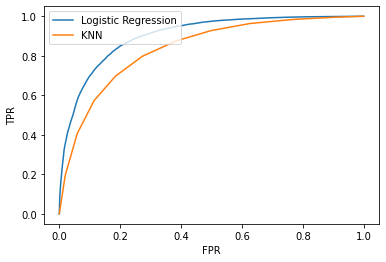

In [52]:
# Plot the RO curves for both models
FPR_list_LR, TPR_list_LR = RO_curve(y_test, y_prob)
FPR_list_KNN, TPR_list_KNN = RO_curve(y_test, y_prob_KNN)
plt.plot(FPR_list_LR, TPR_list_LR, label='Logistic Regression')
plt.plot(FPR_list_KNN, TPR_list_KNN, label='KNN')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=2)

In [53]:
# Compute the auroc for both models with different percentages of the train dataset
list_perc = np.arange(11)[1:]/10
LR_auroc = []
KNN_auroc = []
KNN = KNeighborsClassifier()
#logr = Logistic_regression(x_train.shape[1], max_iteration = 1000)
logr = Logistic_regression(x_train.shape[1], learning_rate = 2e-4, max_iteration = 1e4)

for percentage in list_perc:
    x_train_split = x_train.sample(frac=percentage, replace=False, random_state=100)
    y_train_split = y_train.loc[x_train_split.index,:]
    x_val_split = x_train_split.sample(frac=0.3, replace=False, random_state=100)
    x_train_split = x_train_split.drop(index = x_val_split.index)
    y_val_split = y_train_split.loc[x_val_split.index,:]
    y_train_split = y_train_split.drop(index = y_val_split.index)
    KNN.fit(x_train_split, y_train_split)
    #y_pred_KNN = KNN.predict(x_test)
    y_prob_KNN = np.expand_dims(KNN.predict_proba(x_test)[:,1], axis=1)
    y_prob_LR = logr.predict(x_test.to_numpy(), logr.fit(x_train_split.to_numpy(), x_val_split.to_numpy(), y_train_split.to_numpy(), y_val_split.to_numpy())[2])
    LR_auroc.append(RO_AUC(y_test, y_prob_LR))
    KNN_auroc.append(RO_AUC(y_test, y_prob_KNN))

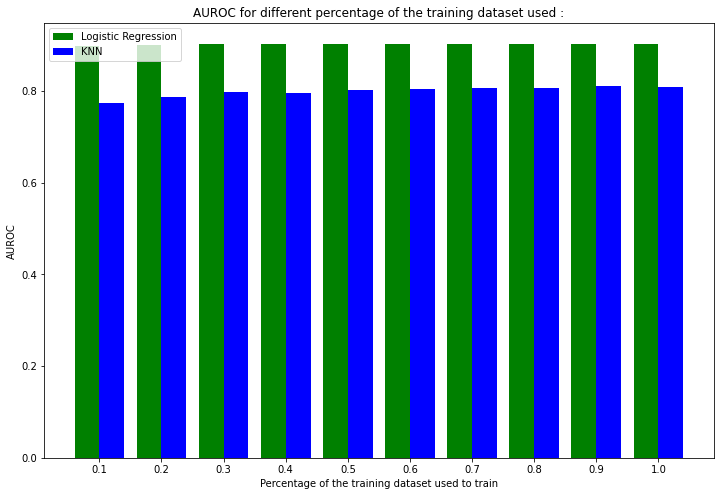

In [54]:
# Plot the result as a bar plot
barWidth = 0.4
plt.figure(figsize =(12, 8))
x_axis = np.arange(len(list_perc))
plt.bar(x_axis - barWidth/2, LR_auroc, color ='g', width = barWidth, label='Logistic Regression')
plt.bar(x_axis + barWidth/2, KNN_auroc, color ='b', width = barWidth, label='KNN')
plt.xticks(x_axis,list_perc)
plt.xlabel('Percentage of the training dataset used to train')
plt.ylabel('AUROC')
plt.title('AUROC for different percentage of the training dataset used :')
plt.legend(loc=2)
plt.show()

#**Multiclass Regression on 20 News Group Dataset**

# Import the libraries

In [55]:
# Import the librairies
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif as mic
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier

# Logistic multinomial model

In [56]:
# Define the class to perform the multinomial logistic regression
class Logistic_multinomial:
    def __init__(self, number_feature, number_class, learning_rate = 0.001, eps = 1e-4, max_iteration = 1000):
        self.number_feature = number_feature
        self.number_class = number_class
        self.learning_rate = learning_rate
        self.eps = eps
        self.max_iteration = max_iteration
        self.list_cross_entropy_train = []
        self.list_cross_entropy_val = []
        self.list_gradient = []
        self.number_iteration_reached = 0

    def gradient(self, X, y, weights_matrix):
        return np.matmul(X.T, self.predict(X, weights_matrix) - y)

    def cross_entropy(self, X, y, weights_matrix):
        return - np.sum(y * np.log(self.predict(X, weights_matrix)))

    def fit(self, X, X_val, y, y_val):
        weights_matrix = np.zeros((self.number_feature, self.number_class))
        grad = self.gradient(X, y, weights_matrix)
        self.list_cross_entropy = []
        self.list_gradient = []
        self.number_iteration_reached = 0
        delta_cross_entropy_val = -np.inf
        cross_entropy_val = np.inf
        while np.linalg.norm(grad) > self.eps and self.number_iteration_reached < self.max_iteration and delta_cross_entropy_val < 0:
            grad = self.gradient(X, y, weights_matrix)
            self.list_gradient.append(np.linalg.norm(grad))
            weights_matrix = weights_matrix - self.learning_rate * grad
            previous_cross_entropy_val = cross_entropy_val
            cross_entropy_val = self.cross_entropy(X_val, y_val, weights_matrix)
            delta_cross_entropy_val = cross_entropy_val - previous_cross_entropy_val
            self.list_cross_entropy_val.append(cross_entropy_val)
            self.list_cross_entropy_train.append(self.cross_entropy(X, y, weights_matrix))
            self.number_iteration_reached = self.number_iteration_reached + 1
        return [self.number_iteration_reached, np.linalg.norm(grad), weights_matrix]
    
    def predict(self, X, weights_matrix):
        y_pred = np.exp(np.matmul(X, weights_matrix))
        y_pred = y_pred / y_pred.sum(axis=1).reshape(len(X),1)
        return y_pred

# Multi-class Accuracy


In [57]:
# Create a function to compute multiclass accuracy
def multiclass_accuracy(y, y_pred):
    accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
    accuracy = accuracy / y.shape[0]
    return accuracy

# Data importation and preparation





In [58]:
# Import the training dataset
newsgroups_train = fetch_20newsgroups(subset='train')

In [59]:
# Print the available news categories
pprint(list(newsgroups_train.target_names))

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [60]:
# Choose the 4 categories to import
categories = ['alt.atheism', 'rec.autos', 'rec.sport.baseball', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories, shuffle=True, random_state=42)

In [61]:
# Vectorize the dataset and create a dataframe
count_vect = CountVectorizer()
news_train = count_vect.fit_transform(newsgroups_train.data)
vocab_news = count_vect.get_feature_names_out()
df_news_train = pd.DataFrame.sparse.from_spmatrix(news_train, columns = vocab_news)
df_news_train

,00,000,0000,00000,000000,000062david42,00041032,0004136,0004246,0004422,...,zur,zurbrin,zus,zwaartepunten,zwak,zwakke,zware,zwarte,zx,zzzzzzt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,132,28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# Create a boolean version of the same dataframe giving a 1 if the world appears at least one time in each sample and 0 otherwise
df_news_int = df_news_train.copy()
for features in df_news_train.columns:
    df_news_int[features] = df_news_train[features] >= 1
df_news_int = df_news_int.astype(int)
df_news_int

,00,000,0000,00000,000000,000062david42,00041032,0004136,0004246,0004422,...,zur,zurbrin,zus,zwaartepunten,zwak,zwakke,zware,zwarte,zx,zzzzzzt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2262,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
# Get the sorted percentage of occurence for each word
df_news_perc = df_news_int.sum()/len(df_news_int)*100
df_news_perc = df_news_perc.to_frame()
df_news_perc.columns = ['%']
df_news_perc = df_news_perc.sort_values(by=['%'], ascending=False)
df_news_perc

,%
the,84.098940
to,71.157244
of,65.724382
and,65.371025
in,61.749117
...,...
meddling,0.044170
bumbry,0.044170
median,0.044170
bum,0.044170


In [64]:
# Drop the words that appear in less than 1% of the documents (too rare) and more than 20% of the documents (too common)
df_news_train = df_news_train.drop(df_news_perc.loc[np.logical_or(df_news_perc >= 20, df_news_perc < 1).to_numpy()].index, axis=1)
df_news_train

,00,000,01,04,10,100,11,12,13,14,...,yeah,year,years,yes,yesterday,yet,york,young,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,132,28,36,0,2,0,0,0,0,0,...,0,0,0,0,2,0,4,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
2260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2262,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [65]:
# Drop the first 82 features which are only numbers
df_news_train = df_news_train.iloc[:,82:]
df_news_train

,ago,agree,ahead,air,al,allen,allow,almost,alomar,alone,...,yeah,year,years,yes,yesterday,yet,york,young,your,yourself
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,4,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
2260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2261,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2262,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [66]:
# Prepare the train datasets
x_train = df_news_train
y_train = pd.get_dummies(pd.DataFrame(newsgroups_train.target, columns = ['Class']), columns = ['Class'])
y_train.columns = newsgroups_train.target_names
y_train

,alt.atheism,rec.autos,rec.sport.baseball,sci.space
0,0,1,0,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,1,0,0
...,...,...,...,...
2259,0,1,0,0
2260,1,0,0,0
2261,0,0,1,0
2262,0,0,0,1


In [67]:
# Use the mutual information method to select a maximum of 100 features
index_to_keep = []
index_trim = 28
for category in range(0,4):
  mi_score = pd.DataFrame(mic(x_train,y_train.iloc[:,category])).sort_values(by=[0], ascending=False).iloc[:index_trim]
  index_to_keep = [*index_to_keep, *mi_score.index]
index_to_keep = list(set(index_to_keep))
x_train_trimmed = x_train.iloc[:,index_to_keep]
x_train_trimmed.columns

Index(['launch', 'launched', 'league', 'tires', 'argument', 'toyota',
       'atheism', 'atheist', 'atheists', 'lunar', 'auto', 'ball', 'baseball',
       'belief', 'mets', 'bible', 'we', 'miles', 'mission', 'bought', 'wheel',
       'braves', 'moon', 'moral', 'morality', 'buy', 'win', 'must', 'cannot',
       'car', 'nasa', 'cars', 'year', 'christian', 'christians', 'your', 'oil',
       'commercial', 'orbit', 'orbital', 'cubs', 'people', 'data', 'dc',
       'phillies', 'dealer', 'pitcher', 'pitching', 'play', 'player',
       'players', 'development', 'drive', 'driver', 'drivers', 'driving',
       'earth', 'program', 'project', 'engine', 'evidence', 'rear', 'exist',
       'religion', 'religious', 'faith', 'fans', 'research', 'rocket',
       'rockets', 'flight', 'runs', 'satellite', 'ford', 'satellites', 'say',
       'front', 'sci', 'funding', 'season', 'game', 'games', 'god', 'shuttle',
       'he', 'solar', 'his', 'hit', 'sox', 'space', 'hitter', 'spacecraft',
       'honda', '

In [68]:
# Normalize to avoid the exponential to become too big when training
for feature in x_train_trimmed.columns:
    mini = x_train_trimmed.loc[:,feature].min()
    maxi = x_train_trimmed.loc[:,feature].max()
    x_train_trimmed.loc[:,feature] = (x_train_trimmed.loc[:,feature] - mini) / (maxi - mini)
x_train_trimmed

,launch,launched,league,tires,argument,toyota,atheism,atheist,atheists,lunar,...,sox,space,hitter,spacecraft,honda,islam,islamic,jesus,team,teams
0,0.0,0.0,0.00,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.25,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2260,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2261,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2262,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0


# Small perturbation


In [69]:
# Small perturbation to validate the correctness of the gradient calculation in the model
C = y_train.shape[1]
D = x_train_trimmed.shape[1]
diff = np.zeros((D, C))
logmulti = Logistic_multinomial(D, C)
weights_matrix = np.random.rand(D, C)
for i in range(D):
    for j in range(C):
        epsilon = np.zeros((D, C))
        epsilon[i, j] = np.random.rand() * 1e-4
        weights_matrix_plus  = weights_matrix  + epsilon
        J_plus = logmulti.cross_entropy(x_train_trimmed.to_numpy(), y_train.to_numpy(), weights_matrix_plus)
        weights_matrix_minus = weights_matrix - epsilon
        J_minus = logmulti.cross_entropy(x_train_trimmed.to_numpy(), y_train.to_numpy(), weights_matrix_minus)
        numeric_grad = (J_plus - J_minus) / (2 * epsilon[i, j])
        derived_grad = logmulti.gradient(x_train_trimmed.to_numpy(), y_train.to_numpy(), weights_matrix)[i, j]
        diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                     np.square(derived_grad + numeric_grad).sum()
print(diff.sum())

1.11843308694932e-14


# Train the model

In [70]:
# Create a validation part to use it as a stopping criteria during the training
x_val_trimmed = x_train_trimmed.sample(frac=0.3, replace=False, random_state=42)
x_train_trimmed_bis = x_train_trimmed.drop(index = x_val_trimmed.index)
y_val = y_train.iloc[x_val_trimmed.index,:]
y_train_bis = y_train.drop(index = y_val.index)
x_val_trimmed

,launch,launched,league,tires,argument,toyota,atheism,atheist,atheists,lunar,...,sox,space,hitter,spacecraft,honda,islam,islamic,jesus,team,teams
1755,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0
1281,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0
350,0.000000,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.125,0.0
420,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0
56,0.020202,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.014085,0.0,0.5,0.000000,0.0,0.0,0.0,0.125,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0
1418,0.000000,0.0,0.000,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.333333,0.0,0.0,0.0,0.000,0.0
841,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0
39,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000,0.0


In [71]:
# Train the model and display the resulting weight matrix
logmulti = Logistic_multinomial(x_train_trimmed.shape[1], y_train.shape[1], learning_rate = 5e-2, max_iteration = 1e4)
weights_matrix = logmulti.fit(x_train_trimmed_bis.to_numpy(), x_val_trimmed.to_numpy(), y_train_bis.to_numpy(), y_val.to_numpy())[2]
weights_matrix = pd.DataFrame(weights_matrix, index = x_train_trimmed.columns, columns = y_train.columns)
weights_matrix

,alt.atheism,rec.autos,rec.sport.baseball,sci.space
launch,-10.504019,-9.541782,-9.882361,29.928162
launched,-8.247979,-9.210334,-5.535301,22.993615
league,-7.244695,-7.454008,23.157363,-8.458660
tires,-6.146424,19.153138,-6.680912,-6.325803
argument,27.391637,-13.713426,-2.045452,-11.632758
...,...,...,...,...
islam,36.690458,-17.057482,-9.387223,-10.245753
islamic,26.860859,-8.296384,-10.305347,-8.259128
jesus,10.077885,-5.726123,-1.991881,-2.359882
team,-13.202205,-12.809646,27.054645,-1.042794


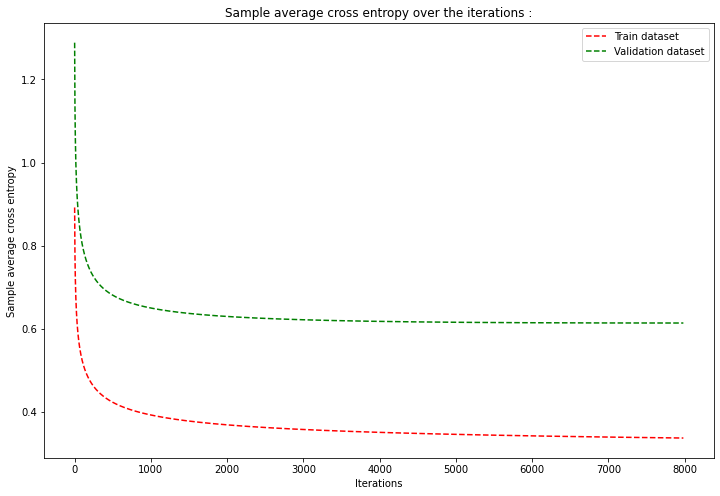

In [72]:
# Plot the training loss over the iterations
fig = plt.subplots(figsize =(12, 8))
plt.plot(list(range(0, logmulti.number_iteration_reached)), np.array(logmulti.list_cross_entropy_train) / x_train_trimmed.shape[0],'r--', label='Train dataset')
plt.plot(list(range(0, logmulti.number_iteration_reached)), np.array(logmulti.list_cross_entropy_val) / x_val_trimmed.shape[0],'g--', label='Validation dataset')
plt.xlabel('Iterations')
plt.ylabel('Sample average cross entropy')
plt.title('Sample average cross entropy over the iterations :')
plt.legend(loc=1)
plt.show()

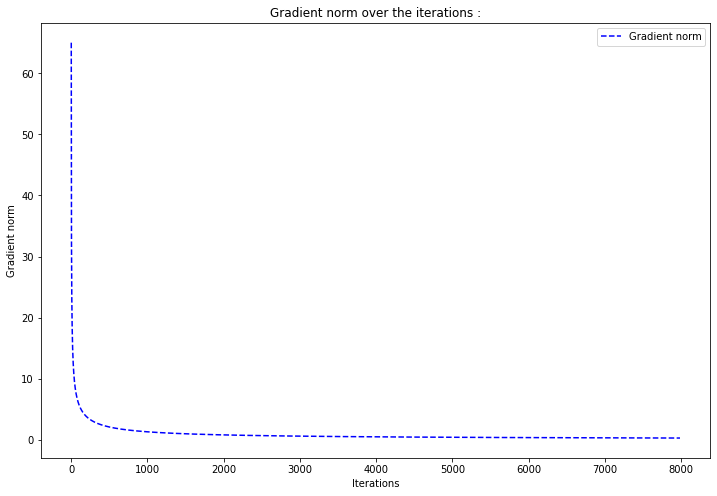

In [73]:
# Plot the gradient norm over the iterations
fig = plt.subplots(figsize =(12, 8))
plt.plot(list(range(0, logmulti.number_iteration_reached)), logmulti.list_gradient,'b--', label='Gradient norm')
plt.xlabel('Iterations')
plt.ylabel('Gradient norm')
plt.title('Gradient norm over the iterations :')
plt.legend(loc=1)
plt.show()

In [74]:
# Print the final norm of the gradient
logmulti.list_gradient[-1]

0.3109033656410937

In [75]:
#Predict on the training set
y_pred_train = logmulti.predict(x_train_trimmed.to_numpy(), weights_matrix.to_numpy())
y_pred_train = pd.DataFrame(y_pred_train, columns = y_train.columns)

print('Multiclass accuracy on training set (%):', round(multiclass_accuracy(y_train.to_numpy(), y_pred_train.to_numpy())*100,1), '%')

Multiclass accuracy on training set (%): 76.9 %


# Test the model

In [76]:
# Import the test dataset using the same methodology
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories, shuffle=True, random_state=42)
count_vect = CountVectorizer()
news_test = count_vect.fit_transform(newsgroups_test.data)
vocab_news = count_vect.get_feature_names_out()
df_news_test = pd.DataFrame.sparse.from_spmatrix(news_test, columns = vocab_news)
df_news_test

,00,000,00000,00041555,0004244402,00043819,00044808,00044939,0004988,0005169,...,zones,zoning,zot,zr16,zubrin,zupcic,zur,zvezdny,zwork,zx
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1504,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Reduce the size of the test to keep only the features used to train the model
x_test_trimmed = df_news_test.loc[:,x_train_trimmed.columns]
x_test_trimmed

,launch,launched,league,tires,argument,toyota,atheism,atheist,atheists,lunar,...,sox,space,hitter,spacecraft,honda,islam,islamic,jesus,team,teams
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1504,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,0


In [78]:
# Normalize the test dataset
for feature in x_test_trimmed.columns:
    mini = x_test_trimmed.loc[:,feature].min()
    maxi = x_test_trimmed.loc[:,feature].max()
    x_test_trimmed.loc[:,feature] = (x_test_trimmed.loc[:,feature] - mini) / (maxi - mini)
x_test_trimmed

,launch,launched,league,tires,argument,toyota,atheism,atheist,atheists,lunar,...,sox,space,hitter,spacecraft,honda,islam,islamic,jesus,team,teams
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0


In [79]:
# Prepare and display y_test
y_test = pd.get_dummies(pd.DataFrame(newsgroups_test.target, columns = ['Class']), columns = ['Class'])
y_test.columns = newsgroups_test.target_names
y_test

,alt.atheism,rec.autos,rec.sport.baseball,sci.space
0,0,0,0,1
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0
...,...,...,...,...
1501,1,0,0,0
1502,0,0,1,0
1503,0,0,0,1
1504,0,0,1,0


In [80]:
# Make prediction on the test dataset
y_pred = logmulti.predict(x_test_trimmed.to_numpy(), weights_matrix.to_numpy())
y_pred = pd.DataFrame(y_pred, columns = y_test.columns)
y_pred

,alt.atheism,rec.autos,rec.sport.baseball,sci.space
0,2.515593e-09,4.695983e-10,1.609036e-10,1.000000e+00
1,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
2,3.408267e-01,3.158111e-04,6.534507e-01,5.406817e-03
3,1.932923e-10,7.805349e-12,1.000000e+00,6.619824e-10
4,2.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01
...,...,...,...,...
1501,3.595821e-01,4.227770e-02,5.597552e-01,3.838499e-02
1502,5.931162e-03,8.577100e-04,9.622239e-01,3.098721e-02
1503,2.422311e-01,3.960564e-01,7.290488e-02,2.888076e-01
1504,3.955157e-15,2.335944e-13,1.000000e+00,1.189431e-11


# Result analysis

In [81]:
# Print the multiclass accuracy in percentage
print('Multiclass accuracy on testing set (%):', round(multiclass_accuracy(y_test.to_numpy(), y_pred.to_numpy())*100,1), '%')

Multiclass accuracy on testing set (%): 71.8 %


In [82]:
# Perform a KNN classification using Sklearn with the default K=5
KNN = KNeighborsClassifier()
KNN.fit(x_train_trimmed, y_train)
y_pred_KNN = KNN.predict(x_test_trimmed)
y_pred_KNN = pd.DataFrame(y_pred_KNN, columns=y_train.columns)
y_pred_KNN

,alt.atheism,rec.autos,rec.sport.baseball,sci.space
0,0,0,0,1
1,0,0,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,0
...,...,...,...,...
1501,0,1,0,0
1502,0,0,1,0
1503,0,0,0,0
1504,0,0,1,0


In [83]:
# Print the KNN multiclass accuracy in percentage
print('KNN multiclass accuracy (%):', round(multiclass_accuracy(y_test.to_numpy(), y_pred_KNN.to_numpy())*100,1), '%')

KNN multiclass accuracy (%): 66.5 %


In [84]:
# Compute the multiclass accuracy for both model with different percentage of the train dataset
list_perc = np.arange(11)[1:]/10
MC_acc = []
KNN_acc = []
KNN = KNeighborsClassifier()
logmulti = Logistic_multinomial(x_train_trimmed.shape[1], y_train.shape[1], max_iteration = 1000)

for percentage in list_perc:
    x_train_split = x_train_trimmed.sample(frac=percentage, replace=False, random_state=42)
    y_train_split = y_train.loc[x_train_split.index,:]
    x_val_split = x_train_split.sample(frac=0.3, replace=False, random_state=42)
    x_train_split = x_train_split.drop(index = x_val_split.index)
    y_val_split = y_train_split.loc[x_val_split.index,:]
    y_train_split = y_train_split.drop(index = y_val_split.index)
    KNN.fit(x_train_split, y_train_split)
    y_pred_KNN = KNN.predict(x_test_trimmed)
    y_pred_MC = logmulti.predict(x_test_trimmed.to_numpy(), logmulti.fit(x_train_split.to_numpy(), x_val_split.to_numpy(), y_train_split.to_numpy(), y_val_split.to_numpy())[2])
    MC_acc.append(multiclass_accuracy(y_test.to_numpy(), y_pred_MC))
    KNN_acc.append(multiclass_accuracy(y_test.to_numpy(), y_pred_KNN))

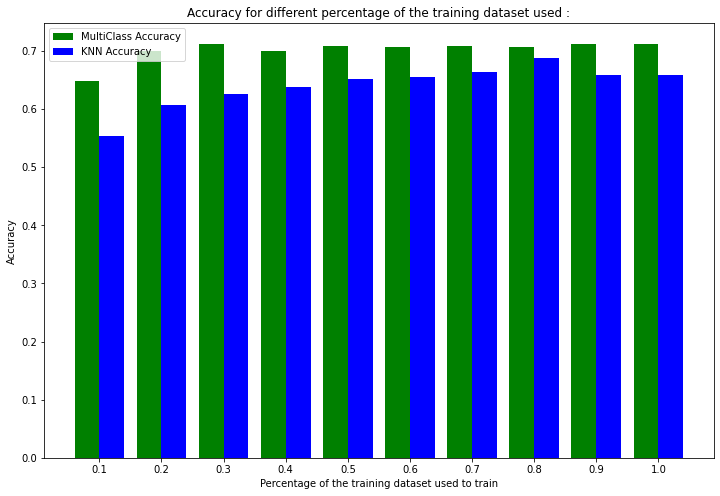

In [85]:
# Plot the result as a bar plot
barWidth = 0.4
plt.figure(figsize =(12, 8))
x_axis = np.arange(len(list_perc))
plt.bar(x_axis - barWidth/2, MC_acc, color ='g', width = barWidth, label='MultiClass Accuracy')
plt.bar(x_axis + barWidth/2, KNN_acc, color ='b', width = barWidth, label='KNN Accuracy')
plt.xticks(x_axis,list_perc)
plt.xlabel('Percentage of the training dataset used to train')
plt.ylabel('Accuracy')
plt.title('Accuracy for different percentage of the training dataset used :')
plt.legend(loc=2)
plt.show()

In [86]:
# Get a concatenated list of the 5 best features for each category
list_best_features = []
for category in weights_matrix.columns:
  best_feature = weights_matrix.nlargest(5, [category]).index
  list_best_features = [*list_best_features,*best_feature]
np.array(list_best_features).T

array(['god', 'religion', 'islam', 'atheist', 'bible', 'car', 'cars',
       'dealer', 'oil', 'driver', 'game', 'games', 'player', 'hit',
       'year', 'space', 'nasa', 'orbit', 'shuttle', 'earth'], dtype='<U8')

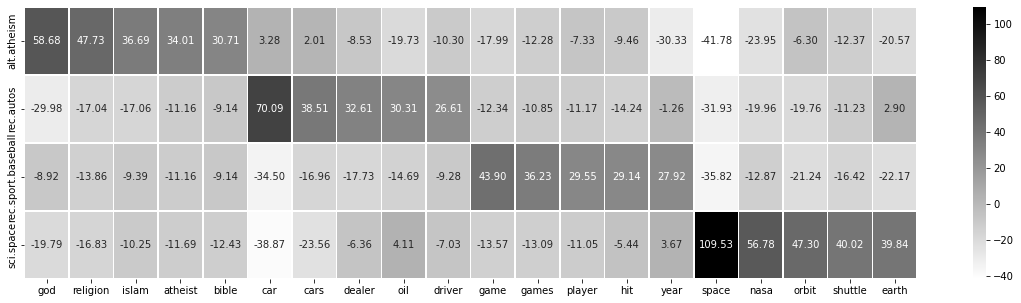

In [88]:
# Print an heatmap matrix containing the 5 best features by categories and rounded weight values
heatmap_matrix = weights_matrix.loc[list_best_features,:]
plt.figure(figsize =(20, 5))
sns.heatmap(heatmap_matrix.T, annot=True, fmt=".2f",cmap=sns.color_palette("binary", as_cmap=True),linewidth=.5)